In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in the <job-id>.out file from the runs, which contains the output of all runs lumped into one file. Read into pandas-DataFrames for easy processing later. Read each run individually (selecting lines to read in with 'skiprows' and 'nrows' arguments), and only the columns that contain numbers (with 'usecols' argument, 'names' to give each column a name).
    
Note: The `*.out` files had a bunch of blank lines in them that I removed (vim: `:g/^$/d` which removed all but one) before reading the files in here.

In [2]:
# Set some file name, parameters
run1_16_file = "buffer-in-one-weakscaling_2.out"
run_32_file = "buffer-in-one-weakscaling32_2.out"
cyc_idx = 3

In [3]:
run1_df = pd.read_csv(run1_16_file, sep=' |=', skiprows=9, header=None, nrows=10, \
                      usecols=[1,3,5,9], names=['cycle','time','dt','zone-cycles/wsec'], engine='python')
run2_df = pd.read_csv(run1_16_file, sep=' |=', skiprows=29, header=None, nrows=10, \
                      usecols=[1,3,5,9], names=['cycle','time','dt','zone-cycles/wsec'], engine='python')
run4_df = pd.read_csv(run1_16_file, sep=' |=', skiprows=49, header=None, nrows=10, \
                      usecols=[1,3,5,9], names=['cycle','time','dt','zone-cycles/wsec'], engine='python')
run8_df = pd.read_csv(run1_16_file, sep=' |=', skiprows=69, header=None, nrows=10, \
                      usecols=[1,3,5,9], names=['cycle','time','dt','zone-cycles/wsec'], engine='python')
run16_df = pd.read_csv(run1_16_file, sep=' |=', skiprows=89, header=None, nrows=10, \
                       usecols=[1,3,5,9], names=['cycle','time','dt','zone-cycles/wsec'], engine='python')
run32_df = pd.read_csv(run_32_file, sep=' |=', skiprows=9, header=None, nrows=10, \
                       usecols=[1,3,5,9], names=['cycle','time','dt','zone-cycles/wsec'], engine='python')

In [4]:
run1_df.dtypes

cycle                 int64
time                float64
dt                  float64
zone-cycles/wsec    float64
dtype: object

Collect all the data into a dataframe for easy plotting
- nGPUs
- zone-cycles/wallsecond (aggregate for the run)
- zone-cycles/wsec (per-cycle values averages over cycles 3-10)
- number of meshblocks

In [5]:
df = pd.DataFrame([1,2,4,8,16,32], columns=['nGPUs'])

In [6]:
zonecycleswallsecond = []
with open("buffer-in-one-weakscaling_2.out", "r") as f:
    lines = f.readlines()
    for l in lines:
        if "zone-cycles/wallsecond" in l:
            tokens = l.split('=')
            zonecycleswallsecond.append(float(tokens[1].strip()))
with open("buffer-in-one-weakscaling32_2.out", "r") as f:
    lines = f.readlines()
    for l in lines:
        if "zone-cycles/wallsecond" in l:
            tokens = l.split('=')
            zonecycleswallsecond.append(float(tokens[1].strip()))

In [7]:
df['zone-cycles/wallsecond'] = pd.Series(zonecycleswallsecond)

In [8]:
nmeshblocks = []
with open("buffer-in-one-weakscaling_2.out", "r") as f:
    lines = f.readlines()
    for l in lines:
        if "Number of MeshBlocks" in l:
            tokens = l.split(';')
            tokens1 = tokens[0].split('=')
            nmeshblocks.append(int(tokens1[1].strip()))
with open("buffer-in-one-weakscaling32_2.out", "r") as f:
    lines = f.readlines()
    for l in lines:
        if "Number of MeshBlocks" in l:
            tokens = l.split(';')
            tokens1 = tokens[0].split('=')
            nmeshblocks.append(int(tokens1[1].strip()))

In [9]:
df['meshblocks'] = pd.Series(nmeshblocks)

In [ ]:
zonecycleswsecavg = [\
    run1_df['zone-cycles/wsec'].iloc[cyc_idx:].mean(),\
    run2_df['zone-cycles/wsec'].iloc[cyc_idx:].mean(),\
    run4_df['zone-cycles/wsec'].iloc[cyc_idx:].mean(),\
    run8_df['zone-cycles/wsec'].iloc[cyc_idx:].mean(),\
    run16_df['zone-cycles/wsec'].iloc[cyc_idx:].mean(),\
    run32_df['zone-cycles/wsec'].iloc[cyc_idx:].mean()\
                    ]

In [11]:
df['avg_zone-cycles/wsec'] = pd.Series(zonecycleswsecavg)

In [12]:
df['zone-cyc/sec/meshblk'] = df['zone-cycles/wallsecond'] / df['meshblocks']
df['avg_zone-cyc/sec/meshblk'] = df['avg_zone-cycles/wsec'] / df['meshblocks']

Let's see what we have

In [13]:
df

,nGPUs,zone-cycles/wallsecond,meshblocks,avg_zone-cycles/wsec,zone-cyc/sec/meshblk,avg_zone-cyc/sec/meshblk
0,1,22300000.0,904,2.230000e+07,24668.141593,24668.141593
1,2,42700000.0,1640,4.268571e+07,26036.585366,26027.874564
2,4,82300000.0,2944,8.230000e+07,27955.163043,27955.163043
3,8,23800000.0,5244,1.293486e+08,4538.520214,24666.012858
4,16,8540000.0,9865,1.152571e+08,865.686771,11683.440736
5,32,9260000.0,18071,1.570343e+08,512.423220,8689.850352


Text(0, 0.5, 'zone-cycles / second / meshblock')

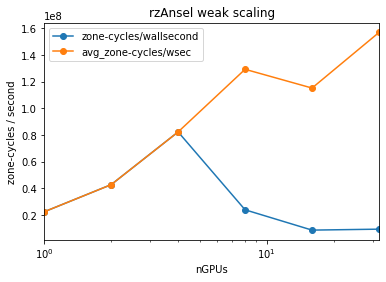

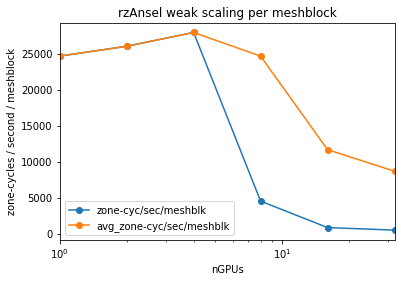

In [15]:
ax = df.plot(kind='line', x='nGPUs', y=['zone-cycles/wallsecond', 'avg_zone-cycles/wsec'], marker='o', \
             logx=True, title='rzAnsel weak scaling')
ax.set_ylabel('zone-cycles / second')
ax1 = df.plot(kind='line', x='nGPUs', y=['zone-cyc/sec/meshblk', 'avg_zone-cyc/sec/meshblk'], marker='o', \
             logx=True, title='rzAnsel weak scaling per meshblock')
ax1.set_ylabel('zone-cycles / second / meshblock')
#plt.show()